<a href="https://colab.research.google.com/github/Yamito548/Apache-pig-pruebas/blob/main/Apache_Pig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Por Dylan Ramírez Bermúdez

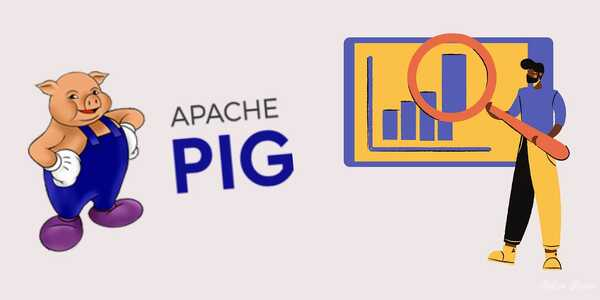

# Descripción de la actividad

In [ ]:
# Ejecute el código proceso_ooiniones.pig que aparece en el siguiente cuaderno de colab en el entorno de Big Data de Cloudera.
# https://colab.research.google.com/drive/1f2wZf5t5jQXrmhxWrN9gUcx3Ab7hRrB2?usp=sharing
# Saque las capturas de pantalla necesarias para justificar la ejecución de este.

# Ejecutamos pig en colab

In [27]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget http://apache.osuosl.org/pig/pig-0.17.0/pig-0.17.0.tar.gz
!tar -xvf pig-0.17.0.tar.gz
!ls

--2024-01-14 13:26:46--  http://apache.osuosl.org/pig/pig-0.17.0/pig-0.17.0.tar.gz
Resolving apache.osuosl.org (apache.osuosl.org)... 64.50.236.52, 64.50.233.100, 140.211.166.134, ...
Connecting to apache.osuosl.org (apache.osuosl.org)|64.50.236.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230606579 (220M) [application/x-gzip]
Saving to: ‘pig-0.17.0.tar.gz.1’

pig-0.17.0.tar.gz.1 100%[===================>] 219.92M  27.8MB/s    in 8.6s    

2024-01-14 13:26:55 (25.6 MB/s) - ‘pig-0.17.0.tar.gz.1’ saved [230606579/230606579]

pig-0.17.0/
pig-0.17.0/bin/
pig-0.17.0/conf/
pig-0.17.0/contrib/
pig-0.17.0/contrib/piggybank/
pig-0.17.0/contrib/piggybank/java/
pig-0.17.0/contrib/piggybank/java/build/
pig-0.17.0/contrib/piggybank/java/build/classes/
pig-0.17.0/contrib/piggybank/java/build/classes/org/
pig-0.17.0/contrib/piggybank/java/build/classes/org/apache/
pig-0.17.0/contrib/piggybank/java/build/classes/org/apache/pig/
pig-0.17.0/contrib/piggybank/java/build/cla

Vemos la versión de pig

In [ ]:
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['PIG_HOME'] = '/content/pig-0.17.0'
os.environ['PATH'] = '%s/bin:%s' % (os.environ['PIG_HOME'], os.environ['PATH'])

!pig -version

#  Ejecutamos el código

Como no se puede ejecutar tal cual pig en colab deberemos almacenarlo en un script.

Pig básico

In [ ]:
%%writefile primero.pig
-- Almacenamiento
messages = LOAD 'messages';
-- Transformación
warns = FILTER messages BY $0 MATCHES '.*WARN+.*';
-- Carga en el HDFS
STORE warns INTO 'warnings';

In [ ]:
#Ejecutamos el código anterior
!pig -x local -f primero.pig
#Básicamente este codigo lo que hace es carga los datos contenidos en 'messages'
#Y filtra los mensajes los cuales contengan la palabra 'warning' y a su vez lo guarda en un
#nuevo archivo llamado 'warnings'
#Esto es útil para ver todos los errores o avisos de manera más sencilla

Pig ectpasswd

In [ ]:
%%writefile segundo.pig
-- 1. Extraccion del etc/passwd
LOAD '/etc/passwd' USING PigStorage(':') AS (user:chararray, \
passwd:chararray, uid:int, gid:int, userinfo:chararray, home:chararray, \
shell:chararray);

-- 2. Transformacion
-- 2.1 agrupacion por shell
grp_shell = GROUP passwd BY shell;
-- 2.2 recuento
counts = FOREACH grp_shell GENERATE group, COUNT(passwd);

-- 3. Carga/Almacenaniento/Volcado
DUMP counts;

In [ ]:
#Ejecutamos el código anterior
!pig -x local -f segundo.pig
#Este carga /ect/passwd y separa la información que contiene entre diferentes shell y los agrupa
#Asigna cada campo a una variable.
#Luego cuenta la cantidad de usuarios para cada tipo de shell
#y ya por último muestra el resultado con Dump.


Proceso de opiniones

In [ ]:
#Nos bajamos los datos
!wget https://github.com/curso-iabd-uclm/hadoop/raw/main/pig/Eopinions.csv

In [ ]:
%%writefile tercero.pig
-- 1.1 Fase de Extracción LOAD
csv_data = LOAD '/user/cloudera/pig/Eopinions.csv' USING PigStorage (',') as
(class:chararray, opinion:chararray);

-- DUMP csv_data; -- para comprobaciones

-- 1.2 Generar colección de comentarios (campo 1)
comentarios = FOREACH csv_data GENERATE $1;

-- DUMP csv_data; -- para comprobaciones

-- 2.1 Procesar cada comentario y trozearlo en palabras
-- TOKENIZE: cadena -> bolsa de palabras (bag of words)
-- FLATTEN: desanida/aplana tuplas bosas de palabras
wordfile_flat = FOREACH comentarios GENERATE FLATTEN (TOKENIZE($0)) as wordin;

-- 2.2 Agrupación por palabras (GROUP BY)
wordfile_grpd = GROUP wordfile_flat by wordin;

-- 2.3 Calculo frecuencia de cada palabra
word_counts = FOREACH wordfile_grpd GENERATE group, COUNT(wordfile_flat.wordin) as cnt;

-- 2.4 Ordenación/Ranking de palabras por frecuencia
word_count_des = ORDER word_counts BY cnt DESC;

-- 3. Carga/almacenamiento
STORE word_count_des into '/user/cloudera/pig/out';

In [ ]:
#Ejecutamos el código anterior
!pig -x local -f tercero.pig
#Se carga los datos y se almacenan en una nueva variable. Se vereifican los datos de la nueva variable.
#Se guarda en una nueva variable las opiniones.
#Se dividien las opiniones en palabras y luego se crea una bolsa de palabras y se agrupan las palabras
#Se orden las palabras por su frecuencia.
#Luego se almacena ese resultado en una nueva variable

Proceso tweets

In [ ]:
#Nos bajamos los datos
!wget https://raw.githubusercontent.com/curso-iabd-uclm/hadoop/main/pig/proceso_tweets.pig
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00438/Health-News-Tweets.zip

In [ ]:
%%writefile cuatro.pig

-- 1.1 Fase de Extracción LOAD
csv_data = LOAD '/user/cloudera/bbchealth.txt' USING PigStorage ('|') as
(tweet_id:chararray, timestamp:chararray, tweet:chararray);

-- DUMP csv_data; -- para comprobaciones

-- 1.2 Generar colección de comentarios (campo 2)
comentarios = FOREACH csv_data GENERATE $2;

-- DUMP csv_data; -- para comprobaciones
--
-- 2.1 Procesar cada comentario y trozearlo en palabras
-- TOKENIZE: cadena -> bolsa de palabras (bag of words)
-- FLATTEN: desanida/aplana tuplas bosas de palabras
wordfile_flat = FOREACH comentarios GENERATE FLATTEN (TOKENIZE($0)) as wordin;

-- 2.2 Agrupación por palabras (GROUP BY)
wordfile_grpd = GROUP wordfile_flat by wordin;

-- 2.3 Calculo frecuencia de cada palabra
word_counts = FOREACH wordfile_grpd GENERATE group, COUNT(wordfile_flat.wordin) as cnt;

-- 2.4 Ordenación/Ranking de palabras por frecuencia
word_count_des = ORDER word_counts BY cnt DESC;

-- 3. Carga/almacenamiento
STORE word_count_des into '/user/cloudera/pig/out';

In [ ]:
#Ejecutamos el código anterior
!pig -x local -f cuatro.pig
#Es basícamente del mismo estilo que el 3º pero con otros datos.

Flume

In [ ]:
#Nos bajamos los datos
!wget https://raw.githubusercontent.com/curso-iabd-uclm/hadoop/main/flume/flume_agent2.properties

In [ ]:
!cat flume_agent2.properties

Ejecutamos

In [ ]:
# flume-ng agent -conf ./ -f ./flume_agent2.properties -n agent1 -Dflume.root.logger=DEBUG